In [43]:
# | default_exp models

# Bayesian GARCH modelling

In [44]:
# | exporti

import abc
from dataclasses import dataclass
from datetime import timedelta
from itertools import product

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpy.typing as npt
import numpyro
import numpyro.distributions as dist
import polars as pl
import seaborn as sns
from jax import random
from numpyro.contrib.control_flow import scan
from numpyro.infer import MCMC, NUTS, Predictive
from tqdm import tqdm

from bayesianfin.data import (
    DataLoader,
    FeatureEngineer,
    LogReturn,
    Variance,
    append_from_log_ret,
)

In [45]:
# | export
az.style.use("arviz-darkgrid")

## Data loading

In this section we follow standard loading processes outlined in my other article.

In [46]:
# | exec: false
# Create a data loader with default parameters and load the data
data_loader = DataLoader()
source_df = data_loader.load_data("./data/ng_daily.csv")
source_df.head()

date,price,ret
date,f64,f64
1997-01-07,3.82,null
1997-01-08,3.8,0.994764
1997-01-09,3.61,0.95
1997-01-10,3.92,1.085873
1997-01-13,4.0,1.020408


In [47]:
# | exec: false
feature_engineer = FeatureEngineer(
    transforms=[
        LogReturn(source_field="ret", feature_name="log_ret"),
    ],
    n_shifts=3,
)
df_with_features = feature_engineer.create_features(source_df)
print(df_with_features.shape)
df_with_features.head()

(7051, 7)


date,price,ret,log_ret,prev_log_ret_1,prev_log_ret_2,prev_log_ret_3
date,f64,f64,f64,f64,f64,f64
1997-01-13,4.0,1.020408,0.020203,0.082384,-0.051293,-0.005249
1997-01-14,4.01,1.0025,0.002497,0.020203,0.082384,-0.051293
1997-01-15,4.34,1.082294,0.079083,0.002497,0.020203,0.082384
1997-01-16,4.71,1.085253,0.081814,0.079083,0.002497,0.020203
1997-01-17,3.91,0.830149,-0.186151,0.081814,0.079083,0.002497


In [48]:
# Cut-off point
T = 300
max_records = 5000
present_value_train, present_value_test = (
    df_with_features["log_ret"][-T - max_records : -T].to_numpy(),
    df_with_features["log_ret"][-T:].to_numpy(),
)
past_values_train, past_values_test = (
    feature_engineer.to_numpy_dict(df_with_features[-T - max_records : -T]),
    feature_engineer.to_numpy_dict(df_with_features[-T:]),
)

## The model

I decided to go for the following process of modelling the log returns:

$$
\begin{aligned}
\log r_t &\sim \mathcal{N}(\mu_t, \sigma_t^2) \\
\log \sigma_t^2 &\sim \mathcal{N}(\mu_{\sigma^2}, \sigma^2_{\sigma^2}) \\
\mu_t &= \alpha_{\mu} + \sum_{i=1}^S \alpha_i \log r_{t-i} \\ 
\mu_{\sigma^2} &= \beta_{\sigma^2} + \sum_{i=1}^S \gamma_i \log \sigma^2_{t-i}
\end{aligned}
$$

There are a few standard components here and the most interesting part in all this is the volatility sampling. We do not directly observe it, but we sample it from the log-normal gaussian and we condition the site on the observed values. During inference time, we just sample it and it in the auto-regressive form.

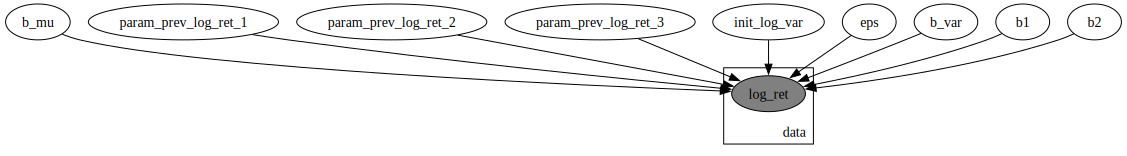

In [49]:
# | export


def garch_model(
    present_value: npt.NDArray, past_values: dict[str, npt.NDArray]
) -> None:
    b_mu = numpyro.sample("b_mu", dist.Normal(0, 0.2))

    coeffs = {}
    for col, s in feature_engineer.get_iterator("log_ret"):
        param_name = feature_engineer.get_shift_pattern(col, s)
        coeffs[param_name] = numpyro.sample(
            f"param_{param_name}", dist.Normal(0.0, 0.5)
        )

    len_observations = len(present_value) if present_value is not None else 1

    init_log_var = numpyro.sample("init_log_var", dist.Normal(0, 1))
    eps = numpyro.sample(
        "eps", dist.Normal(0, 1).expand([len_observations]).to_event(1)
    )

    b_var = numpyro.sample("b_var", dist.Normal(0, 0.2))
    b1 = numpyro.sample("b1", dist.Normal(0, 0.2))
    b2 = numpyro.sample("b2", dist.Normal(0, 0.2))

    def vol_transition(carry, eps_t):
        log_var_prev = carry
        log_var_t = b_var + b1 * log_var_prev + b2 * eps_t
        log_var_t = log_var_t.clip(-1, 5)
        return log_var_t, log_var_t

    _, log_vars = scan(vol_transition, init_log_var, eps)
    variance_array = jnp.exp(log_vars)
    std_array = jnp.sqrt(variance_array)

    mu = b_mu
    for col, s in feature_engineer.get_iterator("log_ret"):
        param_name = feature_engineer.get_shift_pattern(col, s)
        mu += coeffs[param_name] * past_values[param_name]
    with numpyro.plate("data", len_observations):
        numpyro.sample(
            "log_ret",
            dist.Normal(mu, std_array),
            obs=present_value,
        )


numpyro.render_model(
    garch_model,
    model_args=(
        present_value_train,
        past_values_train,
    ),
)

In [50]:
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

# Run NUTS.
kernel = NUTS(garch_model)
num_samples = 2000
mcmc = MCMC(kernel, num_warmup=2000, num_samples=num_samples)

mcmc.run(
    rng_key_,
    present_value=present_value_train,
    past_values=past_values_train,
)
mcmc.print_summary()

posterior_samples = mcmc.get_samples()
idata = az.from_numpyro(mcmc)

sample: 100%|██████████| 4000/4000 [13:00<00:00,  5.13it/s, 1023 steps of size 1.47e-07. acc. prob=0.78]



                            mean       std    median      5.0%     95.0%     n_eff     r_hat
                    b1     -2.04      0.00     -2.04     -2.04     -2.04      1.00      1.00
                    b2     -0.92      0.00     -0.92     -0.92     -0.92      1.00      1.00
                  b_mu     -1.00      0.00     -1.00     -1.00     -1.00      1.00      1.00
                 b_var      0.20      0.00      0.20      0.20      0.20      1.00      1.00
                eps[0]      1.77      0.00      1.77      1.77      1.77      1.00      1.00
                eps[1]     -1.01      0.00     -1.01     -1.01     -1.01      1.00      1.00
                eps[2]     -0.81      0.00     -0.81     -0.81     -0.81      1.00      1.00
                eps[3]      0.90      0.00      0.90      0.90      0.90      1.00      1.00
                eps[4]     -1.57      0.00     -1.57     -1.57     -1.57      1.00      1.00
                eps[5]     -0.88      0.00     -0.88     -0.88     -0

(-1.0, 1.0)

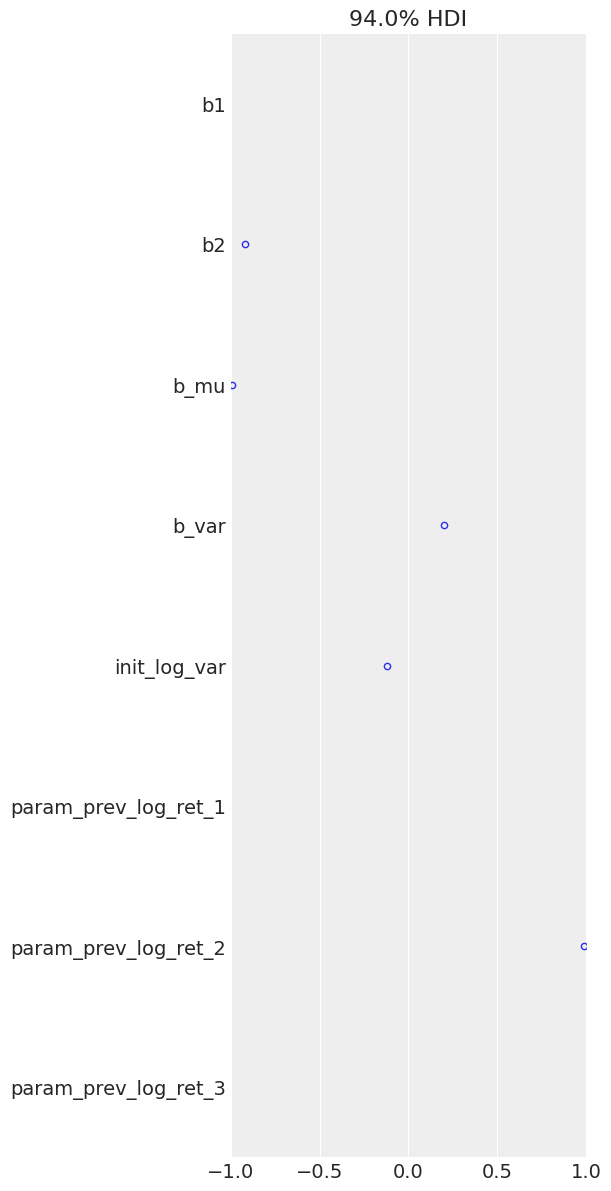

In [51]:
posterior_samples = mcmc.get_samples()
predictive = Predictive(
    garch_model,
    posterior_samples=posterior_samples,
    return_sites=["log_ret"],  # or whatever your observation site is called
)
rng_key, rng_key_ppc = random.split(rng_key)
ppc_samples = predictive(
    rng_key_ppc, present_value=present_value_train, past_values=past_values_train
)

idata = az.from_numpyro(
    mcmc,
    posterior_predictive=ppc_samples,
)
ax = az.plot_forest(
    idata, var_names=[k for k in posterior_samples.keys() if k not in ["eps"]]
)
ax[0].set_xlim([-1, 1])

<Axes: xlabel='log_ret'>

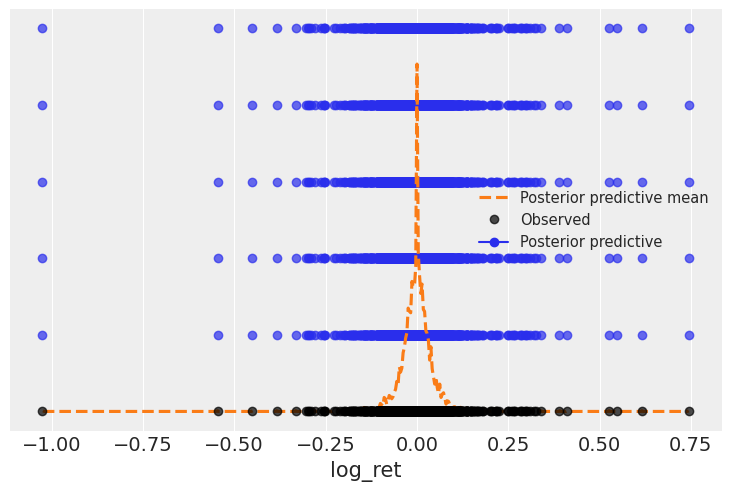

In [52]:
az.plot_ppc(idata, kind="scatter", var_names=["log_ret"])

/Users/sofeikov/work/bayesianfin/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/sofeikov/work/bayesianfin/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/sofeikov/work/bayesianfin/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")
/Users/sofeikov/work/bayesianfin/.venv/lib/python3.12/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single valu

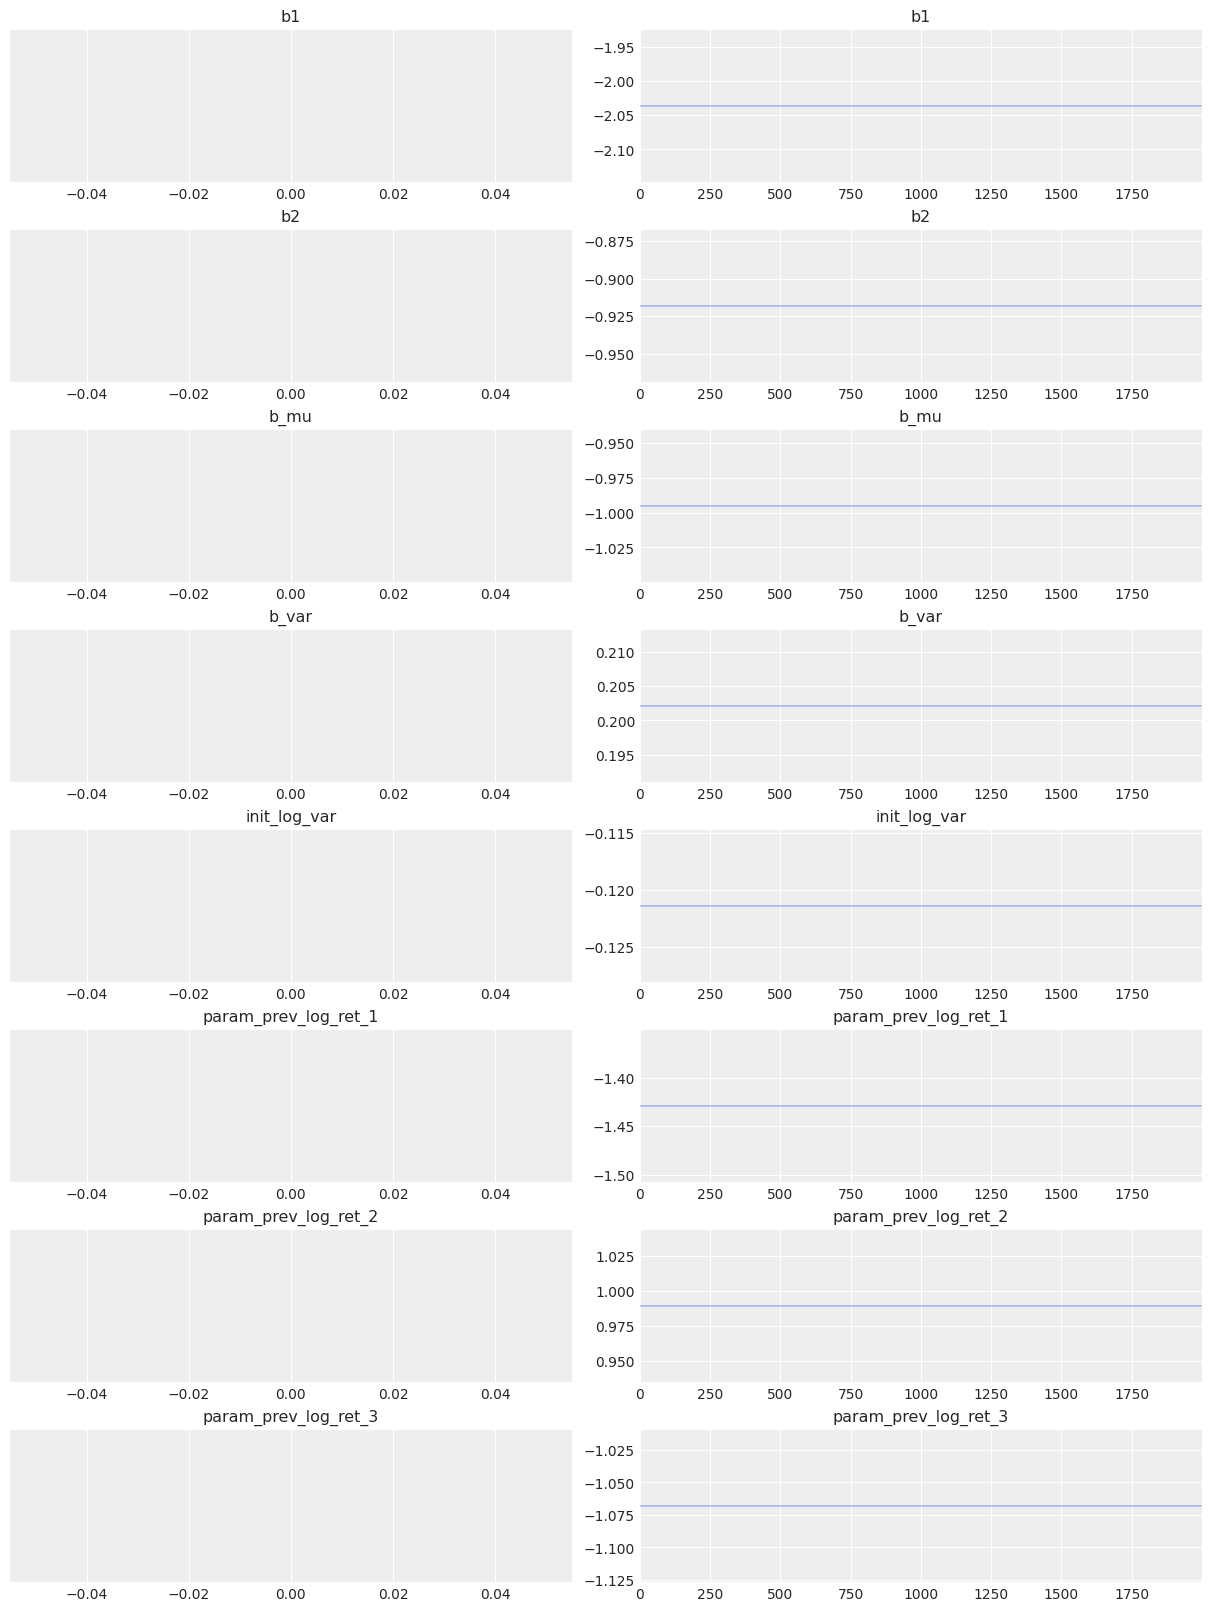

In [53]:
az.plot_trace(idata, var_names=["~eps"]);

In [54]:
num_sims = 10
all_trajectories = []

# We want a single sample when going through the auto-regressive part
posterior_for_gen = {
    k: ps[0:1]
    for k, ps in posterior_samples.items()
    if k not in ("eps", "init_log_var")
}
# posterior_for_gen["eps"] = posterior_samples["eps"][0:1, -2:-1]
target_site = "log_ret"

# Generate some randomness for sampling
rng_key = random.PRNGKey(1)
rng_key, sim_key = random.split(rng_key)
for sim_id in tqdm(range(num_sims)):
    sim_key, traj_key = random.split(sim_key)

    # Create the predictive object to actually sample log returns
    prior_predictive = Predictive(
        garch_model,
        posterior_samples=posterior_for_gen,
        num_samples=1,
    )
    starting_sim_df = source_df[-T - feature_engineer.n_shifts * 5 - 50 : -T]
    feature_sim_df = feature_engineer.create_features(starting_sim_df)
    current_price_shifts = feature_engineer.to_numpy_dict(feature_sim_df[-1])
    for t in range(min(T, 30)):
        traj_key, step_key = random.split(traj_key)
        prior_predictions = prior_predictive(
            step_key,
            present_value=None,
            past_values=current_price_shifts,
        )
        new_log_ret = prior_predictions[target_site].squeeze().item()
        starting_sim_df = append_from_log_ret(starting_sim_df, new_log_ret=new_log_ret)

        # With the new record attached, we re-extract the features.
        feature_sim_df = feature_engineer.create_features(starting_sim_df)
        current_price_shifts = feature_engineer.to_numpy_dict(feature_sim_df[-1])
    all_trajectories.append(starting_sim_df.with_columns(run_id=pl.lit(sim_id)))
all_runs = pl.concat(all_trajectories)


  0%|          | 0/10 [00:00<?, ?it/s]/Users/sofeikov/work/bayesianfin/bayesianfin/data.py:207: RuntimeWarning: invalid value encountered in scalar multiply
  new_price = last_price * new_ret
 10%|█         | 1/10 [00:01<00:14,  1.61s/it]/Users/sofeikov/work/bayesianfin/bayesianfin/data.py:207: RuntimeWarning: invalid value encountered in scalar multiply
  new_price = last_price * new_ret
 20%|██        | 2/10 [00:03<00:13,  1.65s/it]/Users/sofeikov/work/bayesianfin/bayesianfin/data.py:203: RuntimeWarning: overflow encountered in exp
  new_ret = np.exp(new_log_ret)
/Users/sofeikov/work/bayesianfin/bayesianfin/data.py:207: RuntimeWarning: invalid value encountered in scalar multiply
  new_price = last_price * new_ret
 30%|███       | 3/10 [00:04<00:11,  1.61s/it]/Users/sofeikov/work/bayesianfin/bayesianfin/data.py:203: RuntimeWarning: overflow encountered in exp
  new_ret = np.exp(new_log_ret)
 40%|████      | 4/10 [00:06<00:09,  1.60s/it]/Users/sofeikov/work/bayesianfin/bayesianfin/dat

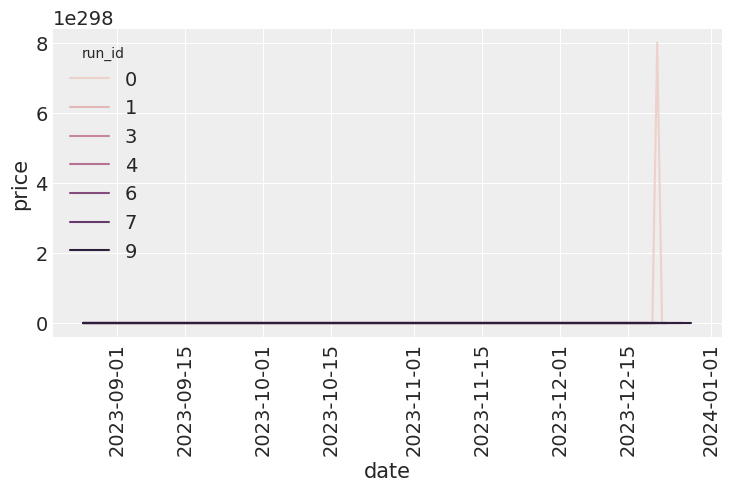

In [55]:
sns.lineplot(all_runs, x="date", y="price", hue="run_id")
plt.xticks(rotation=90);
# plt.ylim([0, 10])